# Multi-step forecasting: recursive approach

In the previous notebooks, we predicted the hourly pollutant concentration for the next 24 hours manually. We will now automate the process and make predictions for various points in the test set.

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load data

In [3]:
# Same function we saw in section 2.

def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor", "RH"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]
    
    ######## NEW #########
    # Add missing timestamps (easier for the demo)
    data = data.asfreq("1H")

    # Fill in missing data.
    data = data.fillna(method="ffill")
    ######################
    
    return data

In [4]:
# Load data.

data = load_data()

data.head()

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


# Feature engineering steps

The same pipeline from the previous notebook.

In [5]:
# Datetime features
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [6]:
# Lag features.

lagf = LagFeatures(
    variables=["CO_sensor", "RH"],  # the input variables
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [7]:
# Window features

winf = WindowFeatures(
    variables=["CO_sensor", "RH"],  # the input variables
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [8]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [9]:
# Drop missing data
imputer = DropMissingData()

In [10]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["CO_sensor", "RH"])

# Feature engineering pipeline

In [11]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

# Split data into train and test

We will leave the last month of data as hold-out sample to evaluate the performance of the model.

Remember that we need data about the pollutant information at least 24 hours before the first forecast point in the test set to create the input features.

In [12]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2005-03-04"][["CO_sensor", "RH"]]
y_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)][[
    "CO_sensor", "RH",
]]

# Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [13]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,
2004-04-05 00:00:00,4,15,0,5,0,0,1188.0,60.8,1224.0,56.5,1165.666667,58.566667,0.866025,-0.5,0.000000,1.000000
2004-04-05 01:00:00,4,15,0,5,1,0,1065.0,65.8,1215.0,59.2,1149.666667,61.800000,0.866025,-0.5,0.269797,0.962917
2004-04-05 02:00:00,4,15,0,5,2,0,999.0,79.2,1115.0,62.4,1084.000000,68.600000,0.866025,-0.5,0.519584,0.854419
2004-04-05 03:00:00,4,15,0,5,3,0,911.0,80.0,1124.0,65.0,991.666667,75.000000,0.866025,-0.5,0.730836,0.682553
2004-04-05 04:00:00,4,15,0,5,4,0,873.0,81.0,1028.0,65.3,927.666667,80.066667,0.866025,-0.5,0.887885,0.460065


In [14]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(8016, 2)
(7992, 2)


In [15]:
# Lasso regression

# We need a prediction for CO concentration
# and a prediction for RH.

lasso = MultiOutputRegressor(Lasso(random_state=0))

# Train the model

lasso.fit(X_train_t, y_train_t)

MultiOutputRegressor(estimator=Lasso(random_state=0))

# Recursive multi-step forecasting: test set

We will forecast for 24 hours for various points in our dataset. 

We could do 24 hour forecasts for every point, or instead, we could forecast the next 24 hours at certain intervals. There are advantages and downsides to each method, which are beyond the scope of this course.

For simplicity, we will forecast 24 hours for every 24 hour interval.

In [16]:
# The first hour of forecast.

data_start = pd.Timestamp("2005-03-04")

In [17]:
# The last hour of forecast (24hs before the last
# timestamp in the test set).

data_end = X_test.iloc[-1].name - pd.offsets.Hour(24)

data_end

Timestamp('2005-04-03 14:00:00', freq='H')

In [18]:
# Each one of the forecasting start points.

forecasting_points = pd.date_range(start=data_start, end=data_end, freq="24H")

print(len(forecasting_points))

forecasting_points

31


DatetimeIndex(['2005-03-04', '2005-03-05', '2005-03-06', '2005-03-07',
               '2005-03-08', '2005-03-09', '2005-03-10', '2005-03-11',
               '2005-03-12', '2005-03-13', '2005-03-14', '2005-03-15',
               '2005-03-16', '2005-03-17', '2005-03-18', '2005-03-19',
               '2005-03-20', '2005-03-21', '2005-03-22', '2005-03-23',
               '2005-03-24', '2005-03-25', '2005-03-26', '2005-03-27',
               '2005-03-28', '2005-03-29', '2005-03-30', '2005-03-31',
               '2005-04-01', '2005-04-02', '2005-04-03'],
              dtype='datetime64[ns]', freq='24H')

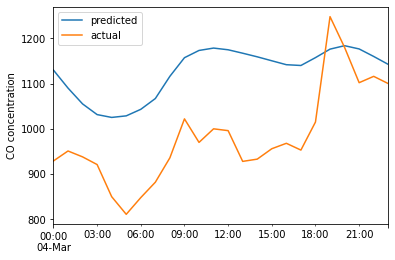

rmse:  163.03247940752763


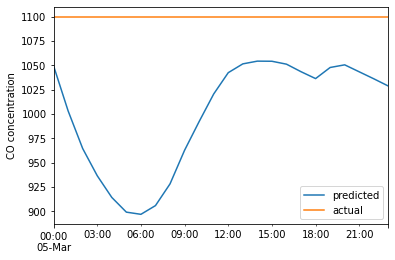

rmse:  114.40237521172669


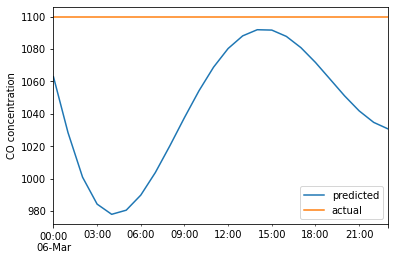

rmse:  68.2790599866606


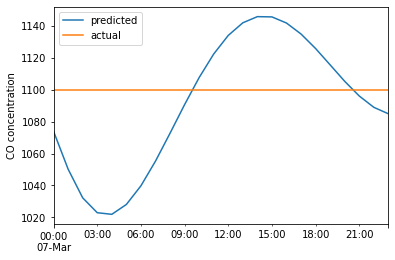

rmse:  42.51098270908371


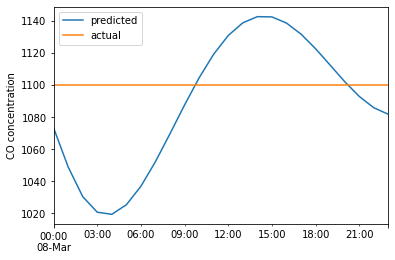

rmse:  42.889131305401


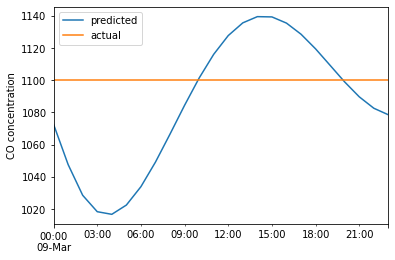

rmse:  43.458399450202606


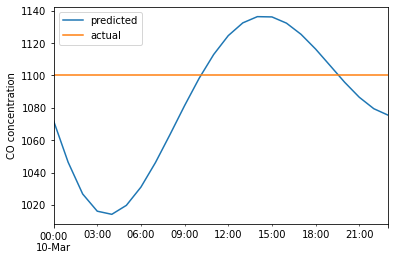

rmse:  44.211405166725186


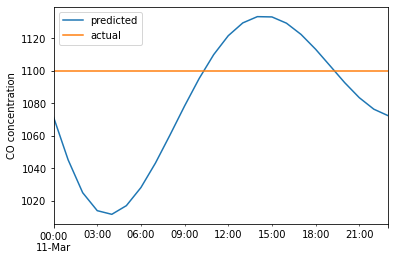

rmse:  45.13895408913288


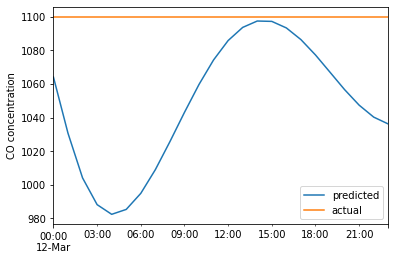

rmse:  64.42005960876229


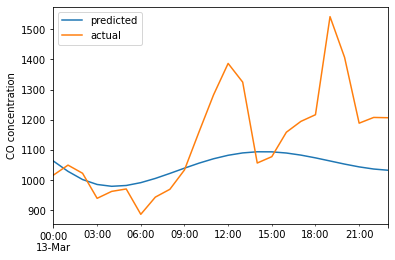

rmse:  170.7833386980848


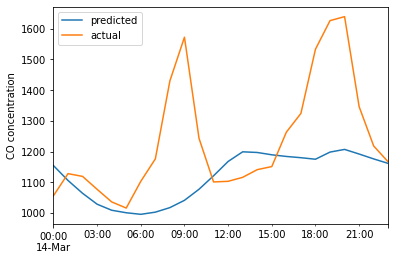

rmse:  214.5009305339832


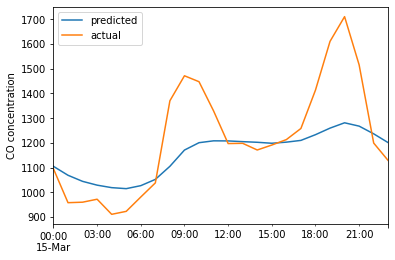

rmse:  169.78381122964717


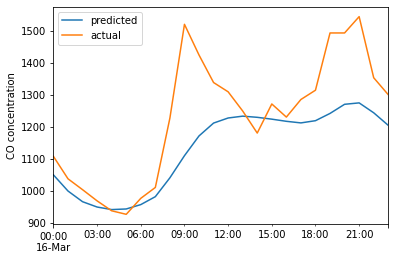

rmse:  147.88583030699857


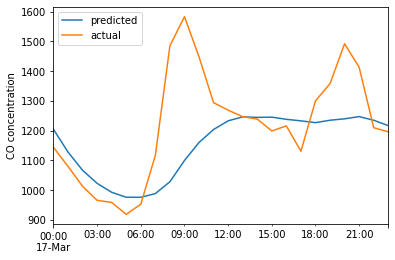

rmse:  169.99835456510027


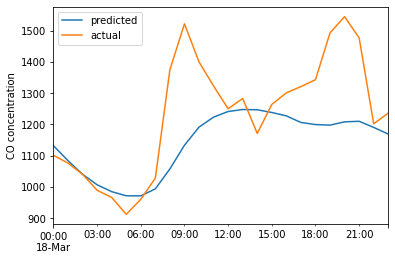

rmse:  162.75401892729846


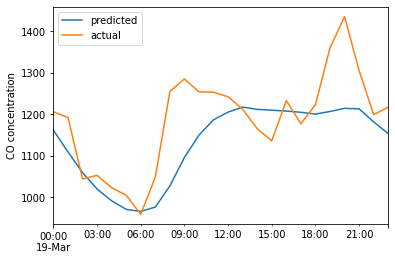

rmse:  94.94665360011861


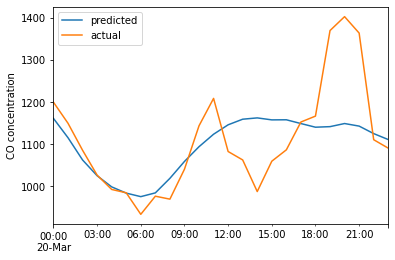

rmse:  100.50759409613448


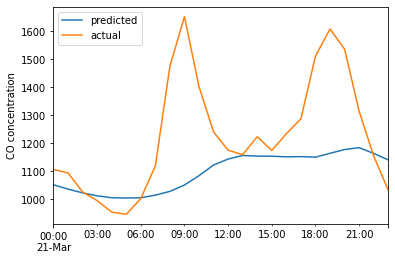

rmse:  225.1051943241208


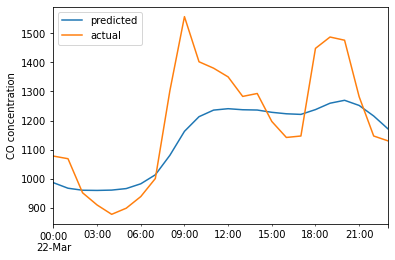

rmse:  140.2085904107995


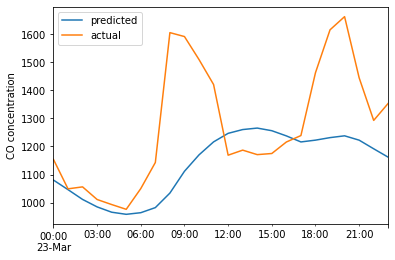

rmse:  229.9143052391646


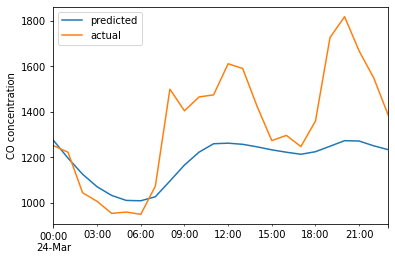

rmse:  244.6647808617025


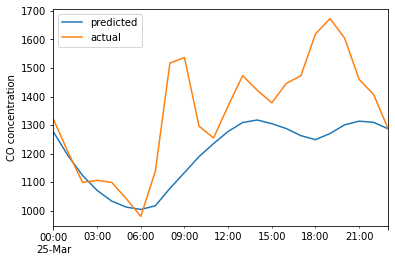

rmse:  197.42379552766818


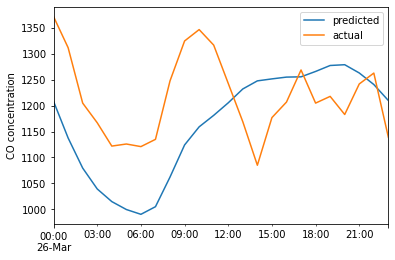

rmse:  119.3590391670532


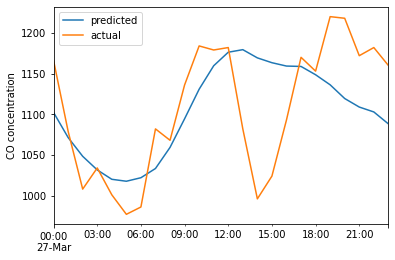

rmse:  68.3537376276246


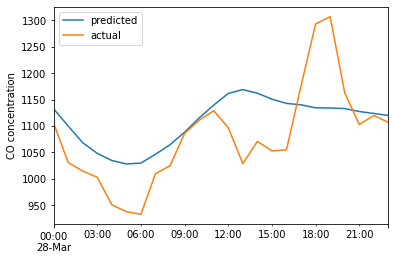

rmse:  77.82720323782097


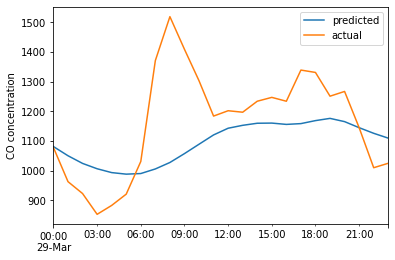

rmse:  174.15943717130523


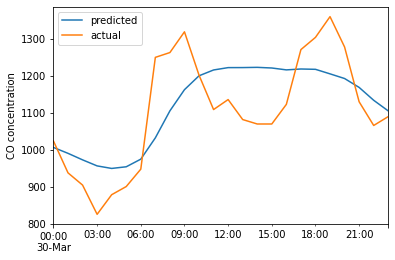

rmse:  106.31204499039323


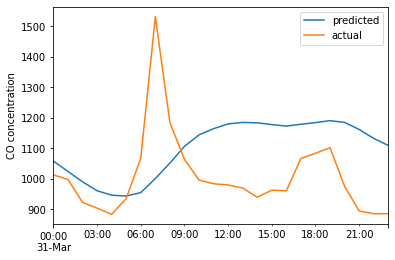

rmse:  190.83064585062817


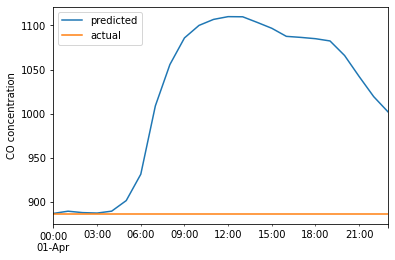

rmse:  160.73279497058954


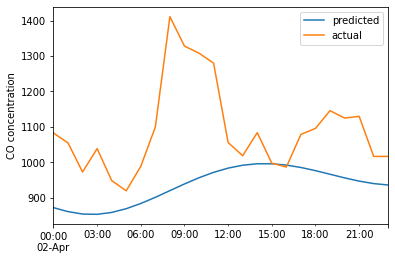

rmse:  198.29367784345794


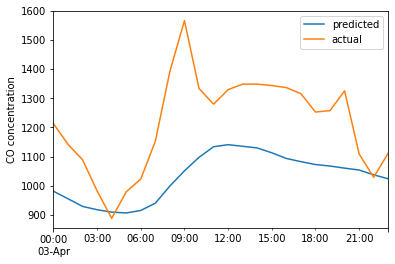

rmse:  216.6728287573693


In [19]:
# List to collect the RMSE for
# each 24 hour forecast examined.

rmse_ls = []

# For every forecast start point:

for forecast_point in forecasting_points:

    ###### Create forecasting horizon #####

    forecast_end = forecast_point + pd.offsets.Hour(23)

    # The timestamps of the horizon
    index = pd.date_range(
        start=forecast_point,
        end=forecast_end,
        freq="1H",
    )

    # the forecasting horizon dataframe
    f_horizon = pd.DataFrame(columns=["CO_sensor", "RH"], index=index)

    ##################################

    ###### the input data #############

    # 24 hs before the first forecasting point
    start_point = forecast_point - pd.offsets.Hour(24)

    # We create input data to obtain the first prediction value.
    input_data = X_test[(X_test.index >= start_point) &
                        (X_test.index < forecast_point)]
    input_data.loc[forecast_point] = np.nan

    ##################################

    # predictions
    pred = lasso.predict(pipe.transform(input_data))[0]

    # Add the prediction to the horizon
    # and to the input data

    f_horizon.loc[forecast_point] = pred
    input_data.loc[forecast_point] = pred

    # repeat for additional points in horizon

    for i in range(23):

        # Re-slice the input data
        start_point = start_point + pd.offsets.Hour(1)
        forecast_point = forecast_point + pd.offsets.Hour(1)

        input_data = input_data[(input_data.index >= start_point)]
        input_data.loc[forecast_point] = np.nan

        # Obtain the prediction
        pred = lasso.predict(pipe.transform(input_data))

        # Add prediction to horizon and input data
        f_horizon.loc[forecast_point] = pred
        input_data.loc[forecast_point] = pred

    # join predictions and grand truth
    tmp = pd.DataFrame(f_horizon["CO_sensor"]).join(
        X_test["CO_sensor"], lsuffix="_left", rsuffix="_right")
    tmp.columns = ["predicted", "actual"]

    tmp.plot()
    plt.ylabel("CO concentration")
    plt.show()

    # Determine the RMSE.
    rmse_ = mean_squared_error(
        y_true=tmp["actual"],
        y_pred=tmp["predicted"],
        squared=False,
    )
    print("rmse: ", rmse_)

    # Append the RMSE to our list.
    rmse_ls.append(rmse_)

In [20]:
# Mean performance across all 24 hr forecast

print("rmse: ", np.mean(rmse_ls), "+-", np.std(rmse_ls))
print("Number of days evaluated: ", len(rmse_ls))

rmse:  135.78585338297697 +- 63.238263701476114
Number of days evaluated:  31


This model seems to capture the seasonality better because a lot of the time features contribute substantially to the prediction.